# Getting started with Brightway

## Install libraries

Install via conda:

Replace `name_of_the_environment` with whatever you like as a name for the new conda environment that will host Brightway and run the command below in a terminal equiped with conda.

Install Brightway

```bash
conda create -n name_of_the_environment -c conda-forge -c cmutel brightway25
```

Activate the new environement

```bash
conda activate name_of_the_environment
```

Install dependencies for this notebook

```bash
conda install -c conda-forge ipykernel matplotlib
```

## Get Ecoinvent account login details from a different file
A common approach is to store such confidential information in a file called `.env` in your project folder. Env stands for (project) environment, and the leading dot in the file name tells your operating system to treat this as a "hidden file". Your `.env` file will be a collection of key-value pairs, separated by an equation sign. For example, it might contain two lines such as:

```bash
ecoinvent_username=utrecht@university.nl
ecoinvent_password=super-duper-safe-password
project_name=Bike LCA project
```

We can then access this information with the `dotenv` and Python's built-in `os` libraries. The cell below contains a pretty standard code snippet that you could reuse in your projects.

Note: if you use Git (e.g GitHub) to manage your project, you will want to add `.env` in your `.gitignore` file to prevent publishing your credentials (e.g. on GitHub).

In [9]:
import os
from dotenv import load_dotenv  # To read the contents of the .env file

load_dotenv(override=True)
ECOINVENT_USERNAME = os.getenv("ecoinvent_username")
ECOINVENT_PASSWORD = os.getenv("ecoinvent_password")
PROJECT_NAME = os.getenv("project_name", "Bike LCA project")

In [3]:
PROJECT_NAME

'20251120-copernicus-tutorial-getting-started-with-brightway'

## Import the Brightway packages

In [4]:
# Brightway package for data management
import bw2data

# Brightway package for importing and exporting data
import bw2io

# Brightway package to compute LCAs or solve LCIs
import bw2calc

# Brightway package with methods to analyze data and run LCA in certain ways (not required for simple LCA)
import bw2analyzer

## Setup Brightway project

> A Brightway project is an isolated set of data sufficient to do LCA calculations.
> 
> Source: https://docs.brightway.dev/en/latest/content/overview/glossary.html#term-Project

In [ ]:
# List available project, in alphabetic order
sorted(bw2data.projects)

In [10]:
# Select (or create if not yet available) the project
bw2data.projects.set_current(name=PROJECT_NAME)

In [8]:
# Verify the current project name
bw2data.projects.current

'copernicus_brightway_tutorial'

### Databases

> A Brightway database is a **container for inventory** nodes. Databases are primarily organization tools, and their precise boundaries are determined by practitioners. Nodes must be associated with one and only one database, but edges can and often do cross from one database to another.
> 
> Brightway does not make a distinction between foreground and background databases.
> 
> Source: https://docs.brightway.dev/en/latest/content/overview/glossary.html#term-Database

In [9]:
# List databases available in the project
bw2data.databases

Databases dictionary with 3 object(s):
	bike
	ecoinvent-3.11-biosphere
	ecoinvent-3.11-cutoff

#### Import Ecoinvent database
Importing Ecoinvent (or other databases) into our Brightway project can be done in a couple of different ways. Here we show the most common way, which is to download it from Ecoinvent's server directly into our project. This requires that we provide our login credentials (username and password).

While it's possible to enter your credentials in-code, we strongly recommend against this. Imagine that you want to share your script with someone or submit it to an open-access journal: your license will be exposed! 

Once we obtained our Ecoinvent username and password, we're ready to import Ecoinvent into our Brightway project. We use Brightway's built-in `import_ecoinvent_release()` function.

In [11]:
# Import ecoinvent (if not already)
if "ecoinvent-3.11-cutoff" not in bw2data.databases:
    bw2io.import_ecoinvent_release(
        version='3.11',
        system_model='cutoff',
        username=ECOINVENT_USERNAME,
        password=ECOINVENT_PASSWORD,
    )

## Modelling the LCA of a simple Ecoinvent activity

In [ ]:
# Make EcoInvent database usable via a Python object
ecoinvent = bw2data.Database('ecoinvent-3.11-cutoff')

### Selecting an activity

Imagine that you want to calculate the GHG footprint of 1 kWh of low voltage electricity in the Netherlands.

We can look on Ecoinvent's ecoQuery if such activity exists and how it is called: https://ecoquery.ecoinvent.org/

We will use this one: https://ecoquery.ecoinvent.org/3.11/cutoff/dataset/7105/documentation

In [8]:
# Searching an activity in the database. Here it is Ecoinvent, but it could be any other database in the current project
activities = ecoinvent.search("market for electricity, low voltage")
# There are many activities with this name
activities

['electricity voltage transformation from medium to low voltage, renewable energy products' (kilowatt hour, CH, None),
 'market group for electricity, low voltage' (kilowatt hour, RER, None),
 'market group for electricity, low voltage' (kilowatt hour, CA, None),
 'market group for electricity, low voltage' (kilowatt hour, RAS, None),
 'market group for electricity, low voltage' (kilowatt hour, IN, None),
 'market group for electricity, low voltage' (kilowatt hour, BR, None),
 'market group for electricity, low voltage' (kilowatt hour, CN, None),
 'market group for electricity, low voltage' (kilowatt hour, RAF, None),
 'market group for electricity, low voltage' (kilowatt hour, CN-SGCC, None),
 'market group for electricity, low voltage' (kilowatt hour, RNA, None),
 'market group for electricity, low voltage' (kilowatt hour, RME, None),
 'market group for electricity, low voltage' (kilowatt hour, US, None),
 'market group for electricity, low voltage' (kilowatt hour, GLO, None),
 'mark

In [ ]:
# Selecting the right one
activity_low_voltage_electricity_NL = ecoinvent.get(
    name="market for electricity, low voltage", 
    location="NL", # Choose Dutch electricity
)
activity_low_voltage_electricity_NL

'market for electricity, low voltage' (kilowatt hour, NL, None)

## Import LCI via Excel

### Importing and matching

In [21]:
# Safety first. We recreate the LCI every time to avoid errors
if 'bike-db' in bw2data.databases:
    del bw2data.databases['bike-db']

In [22]:
# Import LCI from Excel file
excel_lci = bw2io.ExcelImporter("bike-database.xlsx")

Extracted 1 worksheets in 0.01 seconds


In [23]:
# This method is some default data processing that must be called right after importing from Excel
excel_lci.apply_strategies()

Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.22 seconds


The `match_database` method does the heavy lifting of translating the Excel file (e.g. spreadsheet) to Brightway's data structure for databases (e.g. graph). "Matching" means establishing and connecting activities and exchanges in a way that Brightway understands them. We call this method as many times as many databases our LCI connects to, including itself (for internal exchanges).

In [24]:
# Matching the LCI to itself, i.e. activities and exchanges of the foreground LCI (activities in the Excel)
excel_lci.match_database(fields=["name", "unit", "location", "reference product"])

Applying strategy: link_iterable_by_fields


In [25]:
# Matching the LCI to ecoinvent (technosphere exchanges)
excel_lci.match_database("ecoinvent-3.11-cutoff", fields=["name", "unit", "location", "reference product"])

Applying strategy: link_iterable_by_fields


In [26]:
# Matching the LCI to ecoinvent (biosphere exchanges)
# NOTE: Only elementary flows (biosphere exchanges) have a "categories" field
# NOTE 2: Potentially not needed. Follow discussion here: https://stackoverflow.com/questions/79832605/when-to-use-match-database-for-biophere-flows-in-brightway25
excel_lci.match_database("ecoinvent-3.11-biosphere", fields=["name", "categories"])

Applying strategy: link_iterable_by_fields


In [27]:
# Get the overview of our LCI in Brightway. Check if there are unlinked exchanges
excel_lci.statistics()

Graph statistics for `bike-db` importer:
2 graph nodes:
	None: 2
6 graph edges:
	technosphere: 4
	biosphere: 2
6 edges to the following databases:
	ecoinvent-3.11-cutoff: 3
	ecoinvent-3.11-biosphere: 2
	bike-db: 1
0 unique unlinked edges (0 total):




(2, 6, 0, 0)

In [28]:
excel_lci.write_database()

100%|██████████| 2/2 [00:00<00:00, 2375.70it/s]

21:25:32+0100 [info     ] Vacuuming database            


Created database: bike-db


### Using the LCI

In [29]:
# List available databases
bw2io.databases

Databases dictionary with 3 object(s):
	bike-db
	ecoinvent-3.11-biosphere
	ecoinvent-3.11-cutoff

In [ ]:
bike_db = bw2data.Database("bike-db")

In [31]:
# List all activities of the database
for act in bike_db:
    print(act)

'Carbon fibre production' (kilogram, NL, None)
'Bike production' (unit, NL, None)


In [33]:
# Select the bike production activity (our functional unit)
bike = bike_db.get(name="Bike production")

## Setup LCA

### Selecting the LCIA indicator

#### List available LCIA methods and indicators

In [ ]:
# Access available methods in the current project
lcia_methods = bw2data.methods

# List only the first five
list(lcia_methods)[:5]

[('ecoinvent-3.11',
  'CML v4.8 2016 no LT',
  'acidification no LT',
  'acidification (incl. fate, average Europe total, A&B) no LT'),
 ('ecoinvent-3.11',
  'CML v4.8 2016 no LT',
  'climate change no LT',
  'global warming potential (GWP100) no LT'),
 ('ecoinvent-3.11',
  'CML v4.8 2016 no LT',
  'ecotoxicity: freshwater no LT',
  'freshwater aquatic ecotoxicity (FAETP inf) no LT'),
 ('ecoinvent-3.11',
  'CML v4.8 2016 no LT',
  'ecotoxicity: marine no LT',
  'marine aquatic ecotoxicity (MAETP inf) no LT'),
 ('ecoinvent-3.11',
  'CML v4.8 2016 no LT',
  'ecotoxicity: terrestrial no LT',
  'terrestrial ecotoxicity (TETP inf) no LT')]

#### Selecting one LCIA indicator

In [34]:
# Select climate change indicators from EF 3.1 LCIA method that is provided by Ecoinvent
ef3_1_climate_change_lcia_indicator = [
    m 
    for m in bw2data.methods 
    if m[0] == "ecoinvent-3.11" 
    and "climate change" == m[2] 
    and "EF v3.1" == m[1]
][0]
ef3_1_climate_change_lcia_indicator

('ecoinvent-3.11',
 'EF v3.1',
 'climate change',
 'global warming potential (GWP100)')

### Setup the LCA with a functional unit and an indicator

In [ ]:
# Define functional unit as a dictionary of product : amount pairs
functional_unit = { bike: 1 }

# Build the LCA as an object
lca = bw2calc.LCA(
    demand=functional_unit, 
    method=ef3_1_climate_change_lcia_indicator,
)

## Calculate/Running the LCA
This is roughly equivalent to the Calculate button in SimaPro

In [36]:
# Solve the LCI, necessary to compute the LCA.
lca.lci()
# Calculate the LCIA results based on the LCI and the characterization factors from the LCIA method
lca.lcia()

## Final result

In [37]:
lca.score

216.14010998141646

In [39]:
# Same but with some context

print(f'{ef3_1_climate_change_lcia_indicator[3].title()}: {str(round(lca.score, 3))} {bw2data.methods[ef3_1_climate_change_lcia_indicator]['unit']}')

Global Warming Potential (Gwp100): 216.14 kg CO2-Eq


## Contribution analysis

In [60]:
# Needed to generate and manipulate DataFrames
import pandas

In [59]:
# Generate a recursive contributions analysis

contribution_analysis = bw2analyzer.utils.recursive_calculation_to_object(
    activity=bike, 
    lcia_method=ef3_1_climate_change_lcia_indicator,
    amount=1,  # How much of the activity? (same as in our FU)
    max_level=2,  # How many levels deep in the CA do you want to go?
)
#contribution_analysis

In [61]:
# Show contributions as a table

dataframe = pandas.DataFrame(contribution_analysis)
dataframe.set_index('label', inplace=True)
dataframe

,parent,score,fraction,amount,name,key
label,,,,,,
root,None,216.140110,1.000000,1.000000,Bike production,"(bike-db, a874ad9f6b4adecf07126afe98e69ee0)"
root_a,root,195.740821,0.905620,6.000000,Carbon fibre production,"(bike-db, a11081680c3ce6f662803c1b19f3d416)"
root_a_a,root_a,19.760819,0.091426,39.000000,"natural gas pressure reduction, from high to l...","(ecoinvent-3.11-cutoff, b4712b0ec5fd4a12eef0bd..."
root_b,root,4.752358,0.021987,1.500000,market for synthetic rubber,"(ecoinvent-3.11-cutoff, 8a73c5dfd8b1246214ae1a..."
root_b_b,root_b,3.251502,0.015043,1.005378,synthetic rubber production,"(ecoinvent-3.11-cutoff, 0a3bdb26440600649e5ba3..."
root_c,root,15.646931,0.072393,3.000000,"market for steel, chromium steel 18/8, hot rolled","(ecoinvent-3.11-cutoff, 98bfb3753b54cb06950709..."
root_c_a,root_c,13.631286,0.063067,2.609043,"steel production, chromium steel 18/8, hot rolled","(ecoinvent-3.11-cutoff, c408bd7b3f4868cbf51701..."


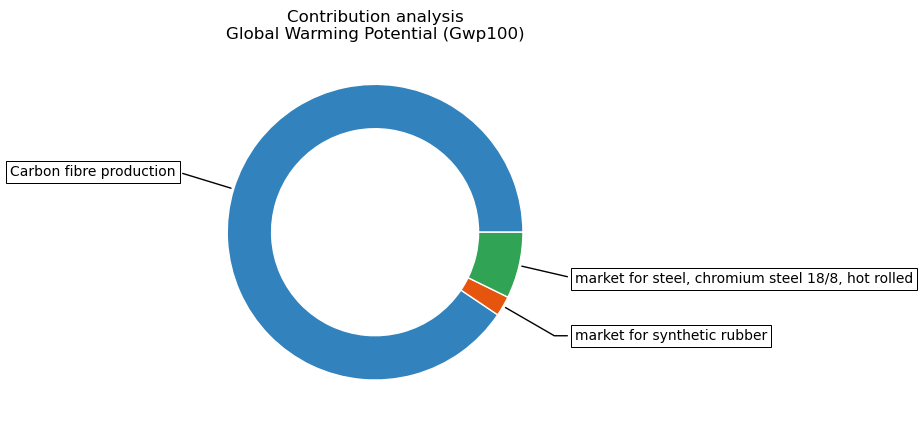

In [44]:
# Create donut pie chart

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

size = 0.3

labels_outer = dataframe[dataframe['parent'] == 'root'].loc[:,'name'].values

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

vals = np.array(dataframe[dataframe['parent'] == 'root']['score'])
# vals = np.array([[impact_a - dataframe.loc['root_a_a']['score'], dataframe.loc['root_a_a']['score']], [dataframe.loc['root_b']['score']], [dataframe.loc['root_c_a']['score']]])

tab20c = plt.color_sequences["tab20c"]
outer_colors = [tab20c[i] for i in [0, 4, 8]]
inner_colors = [tab20c[i] for i in [1, 2, 5, 6, 9, 10]]

wedges, texts = ax.pie(vals, radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'),
       # labels=['Carbon fibre production', 'market for synthetic rubber', 'market for steel,\n chromium steel 18/8,\n hot rolled'],
       )

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels_outer[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)


ax.set(aspect="equal", title=f'Contribution analysis\n{ef3_1_climate_change_lcia_indicator[3].title()}')

plt.show()

In [45]:
# Additional indicator

ef3_1_acidification_lcia_indicator = [
    m for m in bw2data.methods if "acidification" == m[2] and "EF v3.1" == m[1]
].pop()
print(ef3_1_acidification_lcia_indicator)

('ecoinvent-3.11', 'EF v3.1', 'acidification', 'accumulated exceedance (AE)')


In [46]:
# Calculate the scores

lcas = [ { 'method': ef3_1_climate_change_lcia_indicator }, { 'method': ef3_1_acidification_lcia_indicator }, ]

for id in range(len(lcas)):
    lca_temp = bw2calc.LCA(demand={bike: 1}, method=lcas[id]['method'])
    lca_temp.lci()
    lca_temp.lcia()
    lcas[id]['lca'] = lca_temp

    first_tier = []
    for exc in bike.technosphere():
        lca_temp.redo_lcia({bw2data.get_activity(exc['input'])['id']: exc['amount']})
        first_tier.append((exc.input, exc['amount'], lca_temp.score))
        lcas[id]['first_tier'] = first_tier

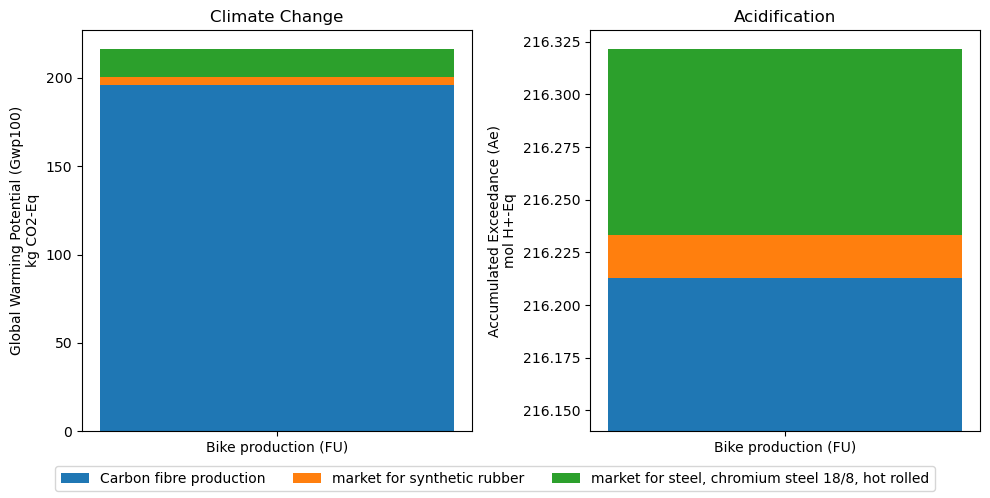

In [53]:
# Create stacked bar chart

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
bottom = np.zeros(3)

tier = f'{bike['name']} (FU)'

for idx, lca in enumerate(lcas):
    pairs = { e[0]['name']: e[2] for e in lca['first_tier'] }
    for boolean, pair in pairs.items():
        p = axes[idx].bar(tier, pair, label=boolean, bottom=bottom)
        bottom += pair

    axes[idx].set_title(lca['method'][2].title())
    axes[idx].set_ylabel(f'{lca['method'][3].title()}\n{bw2data.methods[lca['method']]['unit']}')

handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="outside lower center", ncol=3)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()